In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_cv

/Users/mgx/miniconda3/envs/censor_sam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
import os 
import torch
import cv2
from pprint import pprint
 
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt

In [282]:
model = torch.load("/Users/mgx/Downloads/checkpoint.pth", map_location=torch.device('cpu'))

torch.Size([3, 4000, 3000])
{'boxes': tensor([[1854.2380, 3435.1433, 2284.8357, 3666.2400],
        [1967.4281, 3051.4839, 2088.9023, 3127.1685],
        [2028.7134, 3432.1106, 2274.9941, 3604.4304],
        [1329.7472, 2310.4663, 1372.3457, 2389.2087]]), 'labels': tensor([1, 1, 1, 1]), 'scores': tensor([0.9899, 0.9699, 0.8776, 0.8550])}
torch.Size([3, 4000, 3000])


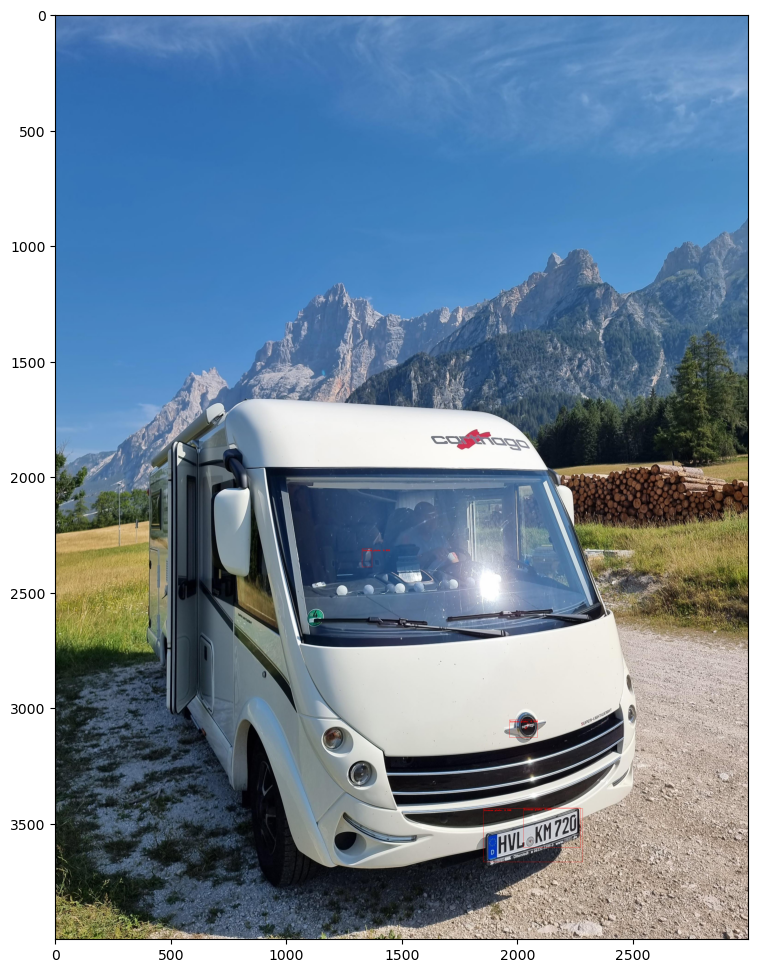

In [283]:
img_path = "/Users/mgx/Library/CloudStorage/GoogleDrive-skatorlp@googlemail.com/Meine Ablage/Licence Plate Detection Dataset v1/train/20220720_101351.jpeg"

image = read_image(img_path) / 255.0
original_image = image
print(image.shape)
device = torch.device('cpu')
model.eval()
with torch.no_grad():
    #x = eval_transform(image)
    x = image
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    print(pred)

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
print(image.shape)
pred_labels = [f"license plate: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

box = pred_boxes[0].tolist()

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV now rescales the images and normalizes them.
        # Just unnormalize such that when KerasCV normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

In [47]:
#model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_base_sa1b")
img_path = "/Users/mgx/Library/CloudStorage/GoogleDrive-skatorlp@googlemail.com/Meine Ablage/Licence Plate Detection Dataset v1/train/20170505_203934.jpeg"
image = np.array(keras.utils.load_img(img_path))
original_image = image
original_resolution = image.shape[:2]
image = inference_resizing(image)

In [286]:
def scale_bbox(input_res, output_res, bbox):
    # input_res and output_res are tuples of (width, height)
    # bbox is a list of [x1, y1, x2, y2] coordinates
    # returns a scaled bbox as a list of [x1, y1, x2, y2] coordinates
    max_scale = min(output_res[0] / input_res[0], output_res[1] / input_res[1]) # scaling factor for the longest side
    scaled_bbox = []
    for i in range(4):
        scaled_bbox.append(int(round(bbox[i] * max_scale)))
    return scaled_bbox

scaled_box = scale_bbox(original_resolution, (1024, 1024), box)
print(original_resolution, box, scaled_box) 

(4000, 3000) [1854, 3435, 2284, 3666] [475, 879, 585, 938]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


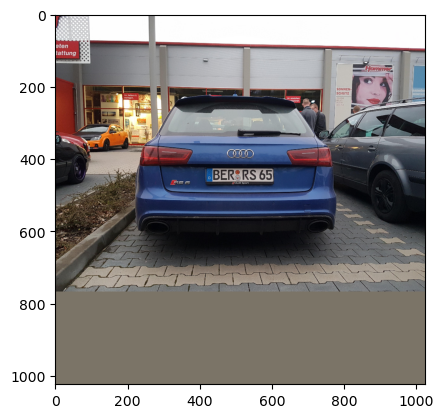

In [8]:
plt.imshow(image / 255.0)

In [68]:
#bboxes_dummy = [[475,879,585,938], [100,1000,650,400], [540, 580,750,450]]
bboxes_dummy = [[210,320,400,410], [620, 350, 800, 410], [390,420,620,480]]
#bboxes_dummy = [[390,420,700,480]]

def parse_bboxes(bboxes):
    # convert the list of bboxes to a numpy array of shape (1,1,2,2)
    new_bboxes = []
    for box in bboxes:
        new_bboxes.append(np.array([[box[0], box[1]], [box[2], box[3]]]))
        
    bboxes = np.array(new_bboxes)
    bboxes = bboxes[np.newaxis, ...]
    return bboxes

def reverse_resizing(mask, image_shape, pad=True):
        print("image shape for resizing", image_shape)
        if pad:
            h, w = image_shape[-2], image_shape[-1]
            print(h, w)
            scale = 1024 * 1.0 / max(h, w)
            new_h = int(h * scale + 0.5)
            new_w = int(w * scale + 0.5)
            print(new_h, new_w)
            mask = mask[:new_h, :new_w]
        # Resize the mask
        #mask = ops.image.resize(mask[None, ...], (h, w))[0]
        mask =cv2.resize(mask, (w, h), interpolation=cv2.INTER_CUBIC)
        # Cast the mask
        mask = ops.cast(mask, dtype="float32")
        print(mask.shape)

        return mask

parse_bboxes(bboxes_dummy)

array([[[[210, 320],
         [400, 410]],

        [[620, 350],
         [800, 410]],

        [[390, 420],
         [620, 480]]]])

In [81]:
outputs["masks"][0][0][..., None][..., 0].shape

(256, 256)

In [82]:
overall_mask = np.zeros(original_resolution, dtype=np.uint8)

for bbox in bboxes_dummy:
    outputs = model.predict(
        {"images": image[np.newaxis, ...], "boxes": parse_bboxes([bbox])}
    )
    mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    mask = mask.astype(np.uint8)
    mask = reverse_resizing(mask, original_resolution)
    overall_mask = np.logical_or(overall_mask, mask)

overall_mask



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(256, 256)
(1024, 1024)
image shape for resizing (3024, 4032)
3024 4032
768 1024
(3024, 4032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(256, 256)
(1024, 1024)
image shape for resizing (3024, 4032)
3024 4032
768 1024
(3024, 4032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(256, 256)
(1024, 1024)
image shape for resizing (3024, 4032)
3024 4032
768 1024
(3024, 4032)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

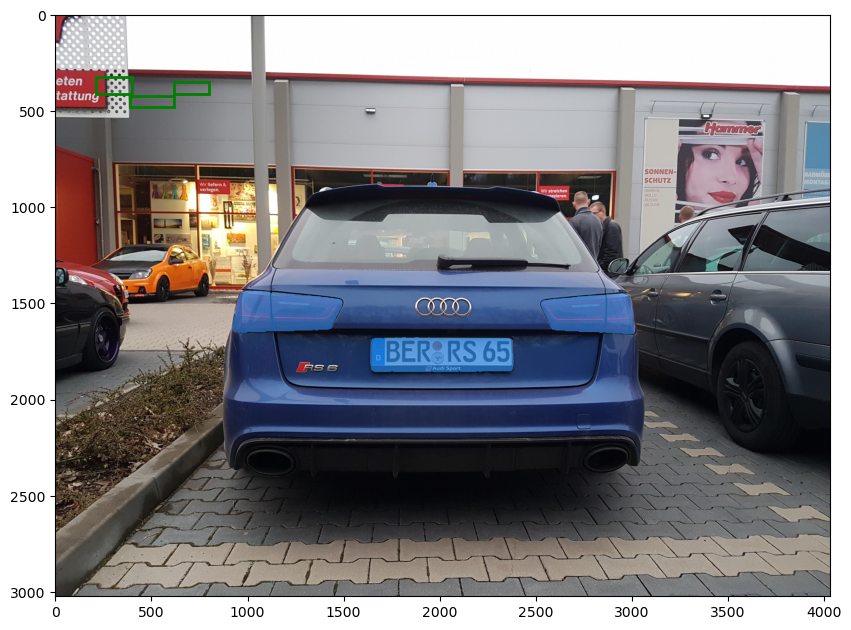

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(original_image) / 255.0)
show_mask(overall_mask, plt.gca())
for box in bboxes_dummy:
    show_box(np.array(box), plt.gca())
#plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


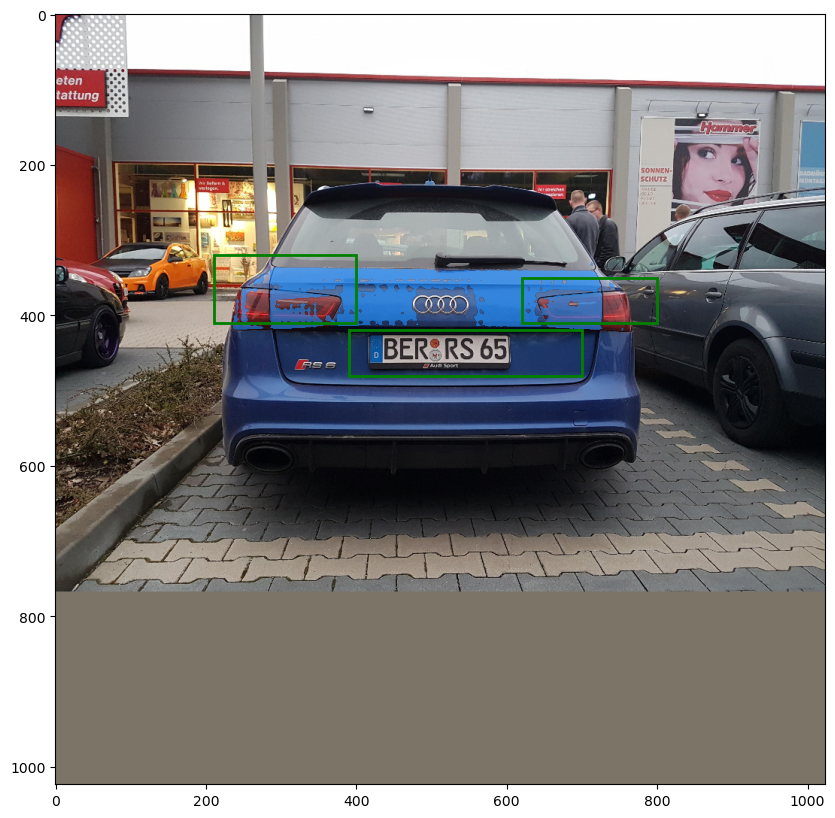

In [23]:
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
for box in bboxes_dummy:
    show_box(np.array(box), plt.gca())
#plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


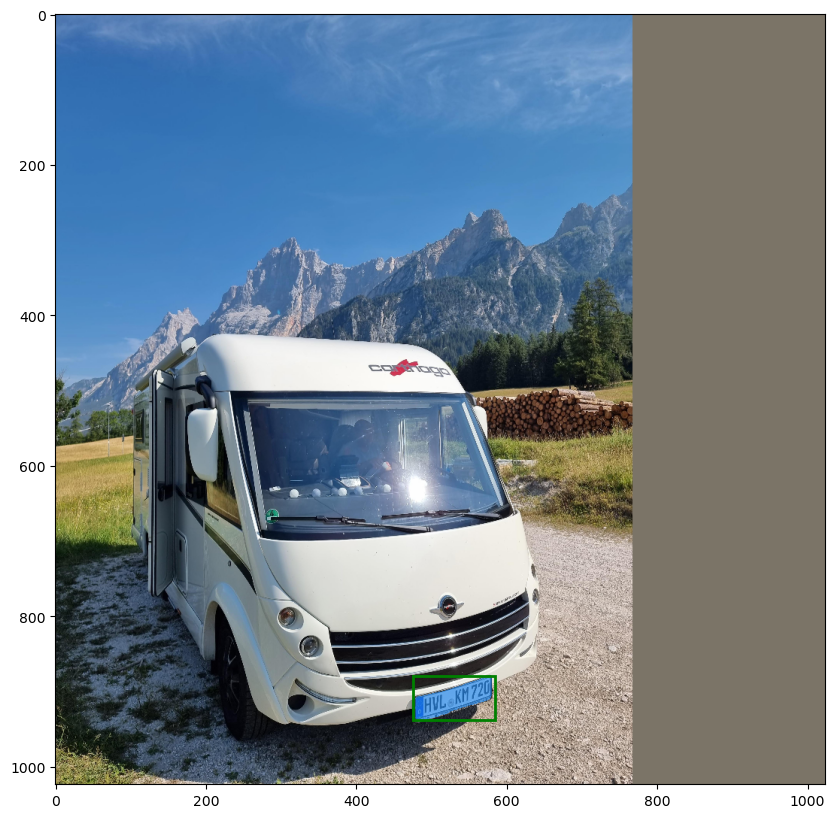

In [ ]:
# Let's specify the box
box = scaled_box
box = [475,879,585,938]
input_box = np.array([[box[0], box[1]], [box[2], box[3]]])

outputs = model.predict(
    {"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
#plt.axis("off")
plt.show()

In [ ]:
import cv2

serialize numpy array to disk and load it

In [ ]:
# turn tensor into numpy array
image2 = ops.convert_to_numpy(image)

In [ ]:
# turn mask into a 3-channel image
mask = mask.astype(np.uint8) * 255

In [41]:
#test_mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]


test_mask = ops.convert_to_numpy(overall_mask) > 0.0

test_mask = test_mask.astype(np.uint8) * 255

test_mask.shape

(1024, 1024)

In [42]:
def reverse_resizing(mask, image, pad=True):
    # Crop the mask
    if pad:
        h, w = image.shape[-2], image.shape[-1]
        print(h, w)
        scale = 1024 * 1.0 / max(h, w)
        new_h = int(h * scale + 0.5)
        new_w = int(w * scale + 0.5)
        print(new_h, new_w)
        mask = mask[:new_h, :new_w]
    # Resize the mask
    #mask = ops.image.resize(mask[None, ...], (h, w))[0]
    mask =cv2.resize(mask, (w, h), interpolation=cv2.INTER_CUBIC)
    # Cast the mask
    mask = ops.cast(mask, dtype=image.dtype)
    print(mask.shape)

    return mask

original_image = ops.convert_to_numpy(original_image)
final_mask = reverse_resizing(test_mask, original_image)
final_mask = ops.convert_to_numpy(final_mask)

4032 3
1024 1
(4032, 3)


In [63]:
final_mask.shape

(4032, 3)

In [59]:
# reshape original_image to opencv format
test_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

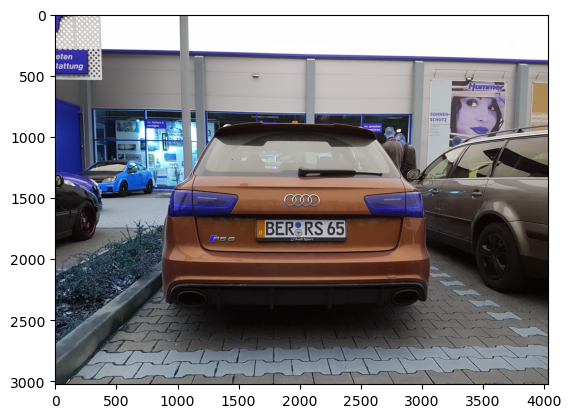

In [60]:
plt.imshow(test_image)

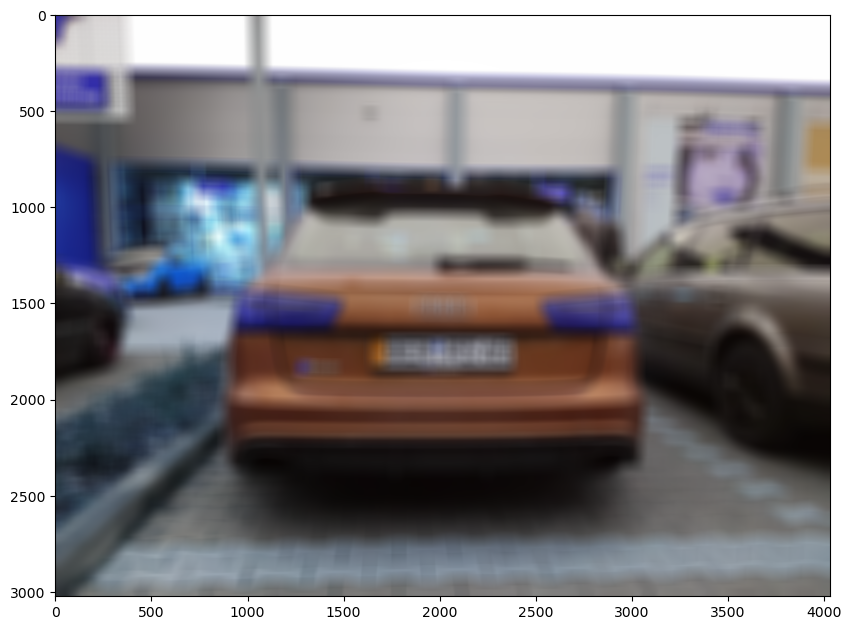

In [61]:
kernel_size = 80
blurred_image = cv2.blur(test_image, (kernel_size, kernel_size))

plt.figure(figsize=(10, 10))
plt.imshow(blurred_image)

In [62]:
mask = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

img1 = cv2.bitwise_and(test_image, test_image, mask= cv2.bitwise_not(np.uint8(final_mask)))
img2 = cv2.bitwise_and(blurred_image, blurred_image, mask= np.uint8(final_mask))

final_image = cv2.add(img1, img2)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


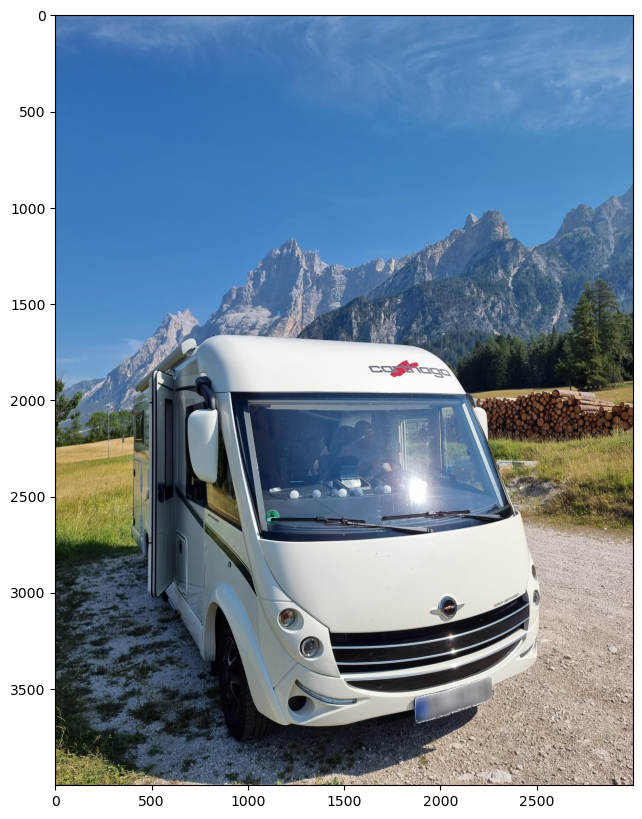

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(final_image)

In [64]:
def censor_image(image_path, mask):
    print(mask.shape, mask.dtype)
    image = np.array(keras.utils.load_img(image_path))
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("before.jpg", image)

    # calculate blur_kernel based on image dimensions
    blur_kernel = int(max(image.shape[:2]) / 100 * 1.5)

    blurred_image = cv2.blur(image, (blur_kernel, blur_kernel))
    cv2.imwrite("blurred.jpg", blurred_image)

    mask = ops.convert_to_numpy(mask)
    mask = mask.astype(np.uint8) * 255

    print(mask.shape, mask.dtype)
    print(image.shape, image.dtype)

    img1 = cv2.bitwise_and(image, image, mask= cv2.bitwise_not(np.uint8(mask)))
    img2 = cv2.bitwise_and(blurred_image, blurred_image, mask= np.uint8(mask))

    final_image = cv2.add(img1, img2)

    return cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

(3024, 4032) bool
(3024, 4032) uint8
(3024, 4032, 3) uint8


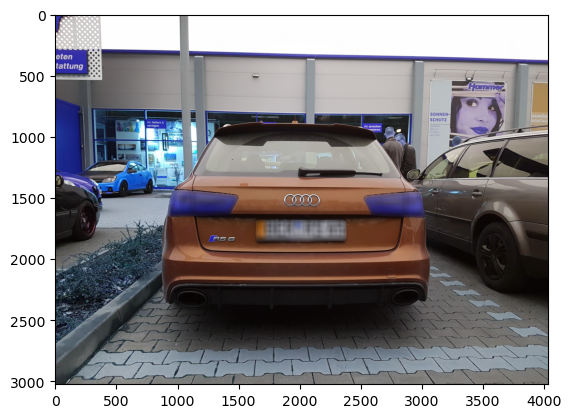

In [74]:
plt.imshow(censor_image("/Users/mgx/Library/CloudStorage/GoogleDrive-skatorlp@googlemail.com/Meine Ablage/Licence Plate Detection Dataset v1/train/20170505_203934.jpeg", overall_mask))

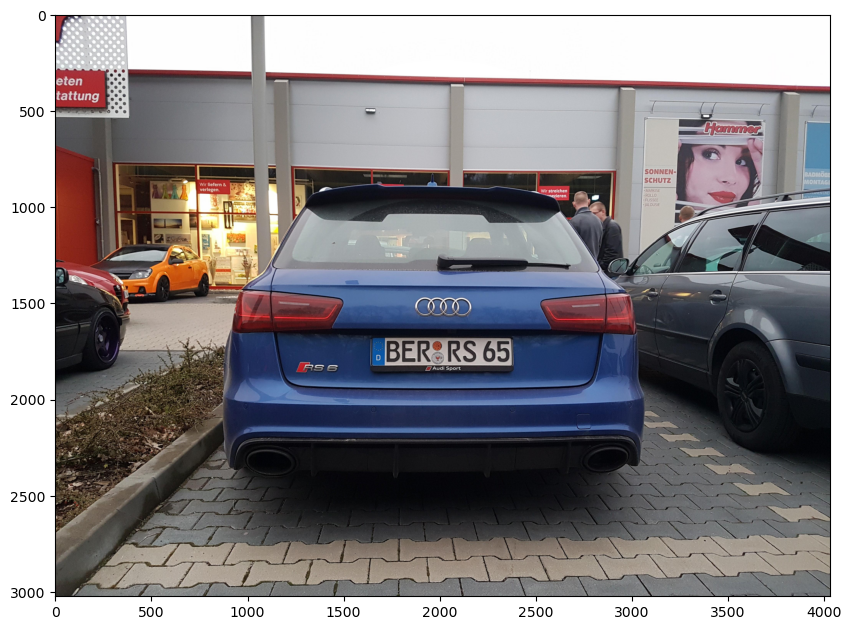

In [75]:
plt.figure(figsize=(10, 10))
plt.imshow(original_image)